In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy import stats
import pickle
import json
from pathlib import Path

In [2]:
# Load the dataset
print("Loading dataset...")
dataset_handle = "hrokrin/the-largest-diamond-dataset-currely-on-kaggle"
filename = "diamonds.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    dataset_handle,
    filename,
)

print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

# Separate numerical and categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Loading dataset...

DATASET OVERVIEW
Shape: 219703 rows × 26 columns

Columns: ['Unnamed: 0', 'cut', 'color', 'clarity', 'carat_weight', 'cut_quality', 'lab', 'symmetry', 'polish', 'eye_clean', 'culet_size', 'culet_condition', 'depth_percent', 'table_percent', 'meas_length', 'meas_width', 'meas_depth', 'girdle_min', 'girdle_max', 'fluor_color', 'fluor_intensity', 'fancy_color_dominant_color', 'fancy_color_secondary_color', 'fancy_color_overtone', 'fancy_color_intensity', 'total_sales_price']

Data types:
Unnamed: 0                       int64
cut                             object
color                           object
clarity                         object
carat_weight                   float64
cut_quality                     object
lab                             object
symmetry                        object
polish                          object
eye_clean                       object
culet_size                      object
culet_condition                 object
depth_percent         

In [3]:
df = df[(df['meas_length'] > 0) & (df['meas_width'] > 0) & (df['meas_depth'] > 0) & (df['total_sales_price'] > 0)]
df = df[df['total_sales_price'] <= 80000]
features = ['cut', 'color', 'clarity', 'carat_weight', 'cut_quality', 'clarity',
            'polish', 'symmetry']

X = df[features]
y = df['total_sales_price']

In [4]:
sum(y > 80000)
max(y[y<98000])

66690

<Axes: >

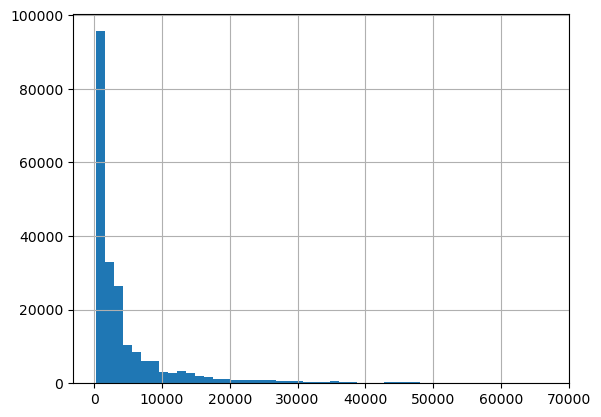

In [5]:
df['total_sales_price'].hist(bins=50)

In [6]:
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Shape: {X.shape[0]} rows × {X.shape[1]} columns")
print(f"\nColumns: {X.columns.tolist()}")
print(f"\nData types:\n{X.dtypes}")

# Separate numerical and categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")


DATASET OVERVIEW
Shape: 215919 rows × 8 columns

Columns: ['cut', 'color', 'clarity', 'carat_weight', 'cut_quality', 'clarity', 'polish', 'symmetry']

Data types:
cut              object
color            object
clarity          object
carat_weight    float64
cut_quality      object
clarity          object
polish           object
symmetry         object
dtype: object


Categorical columns: ['cut', 'color', 'clarity', 'cut_quality', 'clarity', 'polish', 'symmetry']
Numerical columns: ['carat_weight']


In [7]:
for col in categorical_cols:
    unique_values = df[col].unique()
    n_unique = len(unique_values)
    
    print(f"\n📊 {col.upper()}:")
    print(f"   Total unique values: {n_unique}")
    print(f"   Values: {sorted([str(v) for v in unique_values if pd.notna(v)])}")
    
    # Show value counts
    print(f"\n   Distribution:")
    counts = df[col].value_counts()
    for val, count in counts.items():
        print(f"     • {val}: {count} ({count/len(df)*100:.1f}%)")


📊 CUT:
   Total unique values: 11
   Values: ['Asscher', 'Cushion', 'Cushion Modified', 'Emerald', 'Heart', 'Marquise', 'Oval', 'Pear', 'Princess', 'Radiant', 'Round']

   Distribution:
     • Round: 156083 (72.3%)
     • Oval: 13625 (6.3%)
     • Emerald: 10765 (5.0%)
     • Pear: 9603 (4.4%)
     • Princess: 6919 (3.2%)
     • Radiant: 5439 (2.5%)
     • Heart: 4650 (2.2%)
     • Cushion Modified: 3869 (1.8%)
     • Marquise: 2850 (1.3%)
     • Asscher: 1632 (0.8%)
     • Cushion: 484 (0.2%)

📊 COLOR:
   Total unique values: 11
   Values: ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'unknown']

   Distribution:
     • E: 32602 (15.1%)
     • F: 31126 (14.4%)
     • D: 30339 (14.1%)
     • G: 28717 (13.3%)
     • H: 25661 (11.9%)
     • I: 21983 (10.2%)
     • J: 16633 (7.7%)
     • K: 11535 (5.3%)
     • unknown: 8779 (4.1%)
     • L: 5584 (2.6%)
     • M: 2960 (1.4%)

📊 CLARITY:
   Total unique values: 10
   Values: ['I1', 'I2', 'I3', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1',

In [63]:
# 3. Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=44)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=44)

# 4. Transform target to log
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

# 5. Scale numerical features (fit on train only!)
numerical_cols = ['carat_weight']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# 6. One-hot encode categorical (fit on train only!)
categorical_cols = ['cut', 'color', 'clarity', 'cut_quality', 'polish', 'symmetry']
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

# 7. Combine features
X_train_final = np.hstack([
    X_train[numerical_cols].values,
    encoder.transform(X_train[categorical_cols])
])

X_val_final = np.hstack([
    X_val[numerical_cols].values,
    encoder.transform(X_val[categorical_cols])
])

X_test_final = np.hstack([
    X_test[numerical_cols].values,
    encoder.transform(X_test[categorical_cols])
])

In [64]:
# Create output directory
output_dir = Path.cwd().resolve() 
output_dir.mkdir(exist_ok=True)

print("\nSaving preprocessed data...")

# Save arrays
np.save(output_dir / 'X_train_final.npy', X_train_final)
np.save(output_dir / 'X_val_final.npy', X_val_final)
np.save(output_dir / 'X_test_final.npy', X_test_final)

np.save(output_dir / 'y_train_raw.npy', y_train.values)
np.save(output_dir / 'y_val_raw.npy', y_val.values)
np.save(output_dir / 'y_test_raw.npy', y_test.values)

np.save(output_dir / 'y_train_log.npy', y_train_log.values)
np.save(output_dir / 'y_val_log.npy', y_val_log.values)
np.save(output_dir / 'y_test_log.npy', y_test_log.values)

# Save preprocessors
with open(output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(output_dir / 'encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Save metadata
ohe_feature_names = encoder.get_feature_names_out().tolist()
metadata = {
    'numerical_features': numerical_cols,
    'categorical_features': categorical_cols,
    'final_feature_names': numerical_cols + ohe_feature_names,
    'n_features': X_train_final.shape[1],
    'n_train': len(X_train_final),
    'n_val': len(X_val_final),
    'n_test': len(X_test_final),
}
with open(output_dir / 'metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ All data saved to: {output_dir}/")


Saving preprocessed data...
✓ All data saved to: /home/amit.ru/Documents/DL-Project/src/largest_diamond_dataset/data/


In [65]:
# Load features and targets
X_train = np.load('X_train_final.npy')
X_val = np.load('X_val_final.npy')
X_test = np.load('X_test_final.npy')

y_train = np.load('y_train_log.npy')  # Use log version!
y_val = np.load('y_val_log.npy')
y_test = np.load('y_test_log.npy')

In [66]:
X_train[0]

array([1.64826696, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        ])